# Setup

In [2]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot
import logging
import tpvalidator.mcprod.workspace as workspace
import tpvalidator.utilities as utils
import tpvalidator.mcprod.analyzers.snn as snn

from rich import print
from tpvalidator.utilities import temporary_log_level, subplot_autogrid, pandas_backend
from tpvalidator.histograms import uproot_hist_mean_std

from collections import OrderedDict

# Code

In [4]:
from rich import box
from rich.table import Table
from typing import Optional, Dict

def df_to_table(
    pandas_dataframe: pd.DataFrame,
    show_index: bool = True,
    index_name: Optional[str] = None,
    formatters: Optional[Dict[str,str]] = {},
    **kwargs
) -> Table:
    """Convert a pandas.DataFrame obj into a rich.Table obj.
    Args:
        pandas_dataframe (DataFrame): A Pandas DataFrame to be converted to a rich Table.
        rich_table (Table): A rich Table that should be populated by the DataFrame values.
        show_index (bool): Add a column with a row count to the table. Defaults to True.
        index_name (str, optional): The column name to give to the index column. Defaults to None, showing no value.
    Returns:
        Table: The rich Table instance passed, populated with the DataFrame values."""
    rich_table = Table(**kwargs)
    if show_index:
        index_name = str(index_name) if index_name else ""
        rich_table.add_column(index_name)

    for column in pandas_dataframe.columns:
        rich_table.add_column(str(column))

    for row in pandas_dataframe.itertuples():
        t_row = [str(row[0])] if show_index else []
        r = row._asdict()
        for c in pandas_dataframe.columns:
            fmt = formatters.get(c,'{}')
            t_row.append(fmt.format(r[c]))
        rich_table.add_row(*t_row)

    #     rich_table.add_row(*row)

    return rich_table

In [5]:
from typing import Tuple, Optional, Union, Sequence, Dict, List
from rich.table import Table
from tpvalidator.mcprod.geometry import FDVDGeometry_1x6x8


def make_rates_table_from_workspaces( 
        datasets : Dict[str,workspace.TriggerPrimitivesWorkspace], 
        preselection: str = '', 
        per:str='chan', 
        ro_win_len: int=None) -> pd.DataFrame:
    """
    Calculates the TP rates of each workspace in the dataset list.
    The rate is calculated over the chosen unit specified by the `per` argument: channel, crp, tpc or detector.
    The rates are displayed per unit and per view.

    If a preselection is specified, this is applied to all datasets before the rate calculation.
    The readout window lenght, needed for the rate estimate, is passed as argument.
    """
    
    # Constants : move them somewhere else
    sampling_period = 0.5e-6

    num_el_map = {
        'chan' : lambda v: FDVDGeometry_1x6x8.crp_num_chans_by_view_sim(v)*FDVDGeometry_1x6x8.num_crps,
        'crp' : lambda _: FDVDGeometry_1x6x8.num_crps,
        'tpc' : lambda _: FDVDGeometry_1x6x8.num_tpcs,
        'det' : lambda _: 1,
    }
    
    num_el = num_el_map[per]

    rows=[]
    for s, ws in datasets.items():
        num_ev = ws.num_events
        # Throw if not available
        ro_win_len = ws._info_extra['readout_window'] if ro_win_len is None else ro_win_len

        total_time = num_ev*ro_win_len*sampling_period 
        tps_sel = ws.tps.query(preselection) if preselection else ws.tps
        tp_rates = []
        for v in range(3):
            num_els = num_el(v)
            tp_rate = len(tps_sel.query(f'readout_view == {v}'))/total_time/num_els
            tp_rates += [tp_rate]
        rows += [(s, total_time, *tp_rates)]

    df = pd.DataFrame(
        np.array(rows, dtype=[("dataset",object), ("time",float), ("U",float), ("V",float), ("X",float)]),
        columns=['dataset','time', 'U', 'V', 'X']
    )

    return df

In [6]:
def make_vd_rates_table_2(datasets : Dict[str,pd.DataFrame], num_events, preselection: str = '', per:str='chan', title: str='', ro_win_len: int=None, sampling_period=5e-6) -> Table:

    num_el_map = {
        'chan' : lambda v: FDVDGeometry_1x6x8.crp_num_chans_by_view_sim(v)*FDVDGeometry_1x6x8.num_crps,
        'crp' : lambda _: FDVDGeometry_1x6x8.num_crps,
        'tpc' : lambda _: FDVDGeometry_1x6x8.num_tpcs,
        'det' : lambda _: 1,
    }

    num_el = num_el_map[per]

    t = Table('sample', 'time', 'U', 'V', 'X', title=title)
    for s, df in datasets.items():
        num_ev = num_events
        
        # Throw if not available
        ro_win_len = df.extra_info['readout_window'] if ro_win_len is None else ro_win_len

        total_time = num_ev*ro_win_len*sampling_period
        row = [s, f'{total_time:.3f} s']
        tps_sel = df.query(preselection) if preselection else df
        for v in range(3):
            num_els = num_el(v)
            noise_rate = len(tps_sel.query(f'readout_view == {v}'))/total_time/num_els
            row += [f'{noise_rate:.2f} Hz']
        t.add_row(*row)
    return t

# Data

In [7]:
dataset_info = {
    'readout_window' : 8500
}



from pathlib import Path
pre_prod_dir = Path('../../data/vd/pre_prod/')

with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.WARN):
    mu_ws = workspace.TriggerPrimitivesWorkspace(pre_prod_dir / 'anatree_vd_muminus_hist.root', extra_info=dataset_info)

mu_ws.add_rawdigits(pre_prod_dir / 'rawdigits' / 'trigger_digits_hists_detsim_vd_muminus.root')
print(mu_ws.info)

with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.WARN):
    em_ws = workspace.TriggerPrimitivesWorkspace(pre_prod_dir / 'anatree_vd_eminus_hist.root', extra_info=dataset_info)

em_ws.add_rawdigits(pre_prod_dir / 'rawdigits' / 'trigger_digits_hists_detsim_vd_eminus.root')
print(em_ws.info)

with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.WARN):
    gm_ws = workspace.TriggerPrimitivesWorkspace(pre_prod_dir / 'anatree_vd_gamma_hist.root', extra_info=dataset_info)

gm_ws.add_rawdigits(pre_prod_dir / 'rawdigits' / 'trigger_digits_hists_detsim_vd_gamma.root')
print(gm_ws.info)


with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.WARN):
    ar39_ws = workspace.TriggerPrimitivesWorkspace(pre_prod_dir / 'anatree_vd_ar39_hist.root', extra_info=dataset_info)

ar39_ws.add_rawdigits(pre_prod_dir / 'rawdigits' / 'trigger_digits_hists_detsim_vd_ar39.root')

print(ar39_ws.info)


with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.WARN):
    rad_ws = workspace.TriggerPrimitivesWorkspace(pre_prod_dir / 'anatree_vd_radiols_hist.root', extra_info=dataset_info)
rad_ws.add_rawdigits(pre_prod_dir / 'rawdigits' / 'trigger_digits_hists_detsim_vd_radiols.root')

print(rad_ws.info)


datasets = {
    'e-minus': em_ws,
    'gamma': gm_ws,
    'mu-minus': mu_ws,
    'ar39': ar39_ws,
    'radiols': rad_ws
}


None

{
    'backtracker': {'TPAlgTPCSimpleThreshold': {'offset_U': 8, 'offset_V': 1, 'offset_X': -7}},
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'tpg': {
        'tpmakerTPCSimpleThreshold::TriggerPrimitiveMaker': {
            'threshold_tpg_plane0': 45,
            'threshold_tpg_plane1': 45,
            'threshold_tpg_plane2': 45,
            'tool': 'TPAlgTPCSimpleThreshold'
        }
    }
}

None

{
    'backtracker': {'TPAlgTPCSimpleThreshold': {'offset_U': 8, 'offset_V': 1, 'offset_X': -7}},
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'tpg': {
        'tpmakerTPCSimpleThreshold::TriggerPrimitiveMaker': {
            'threshold_tpg_plane0': 45,
            'threshold_tpg_plane1': 45,
            'threshold_tpg_plane2': 45,
            'tool': 'TPAlgTPCSimpleThreshold'
        }
    }
}

None

{
    'backtracker': {'TPAlgTPCSimpleThreshold': {'offset_U': 8, 'offset_V': 1, 'offset_X': -7}},
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'tpg': {
        'tpmakerTPCSimpleThreshold::TriggerPrimitiveMaker': {
            'threshold_tpg_plane0': 45,
            'threshold_tpg_plane1': 45,
            'threshold_tpg_plane2': 45,
            'tool': 'TPAlgTPCSimpleThreshold'
        }
    }
}

None

{
    'backtracker': {'TPAlgTPCSimpleThreshold': {'offset_U': 8, 'offset_V': 1, 'offset_X': -7}},
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'tpg': {
        'tpmakerTPCSimpleThreshold::TriggerPrimitiveMaker': {
            'threshold_tpg_plane0': 45,
            'threshold_tpg_plane1': 45,
            'threshold_tpg_plane2': 45,
            'tool': 'TPAlgTPCSimpleThreshold'
        }
    }
}

None

{
    'backtracker': {'TPAlgTPCSimpleThreshold': {'offset_U': 8, 'offset_V': 1, 'offset_X': -7}},
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'tpg': {
        'tpmakerTPCSimpleThreshold::TriggerPrimitiveMaker': {
            'threshold_tpg_plane0': 45,
            'threshold_tpg_plane1': 45,
            'threshold_tpg_plane2': 45,
            'tool': 'TPAlgTPCSimpleThreshold'
        }
    }
}

In [8]:
# Sanitize TPs
# This cut removes TPs in regions where the sim/backtracking response is ambiguous :
# - sample_peak < 100 : reduced backtracking efficiency
# - sample_peak > 8100 : missing ides
wirecell_ides_cut = 'sample_peak > 100 & sample_peak < 8100'

for n, df in datasets.items():
    df.tps.query(wirecell_ides_cut, inplace=True)
    df.tps.extra_info['readout_window'] = 8000

# MC particles spectra

This is useful to tell the expected energy of clusters from background

Text(0.5, 1.0, 'MCParticles (G4)')

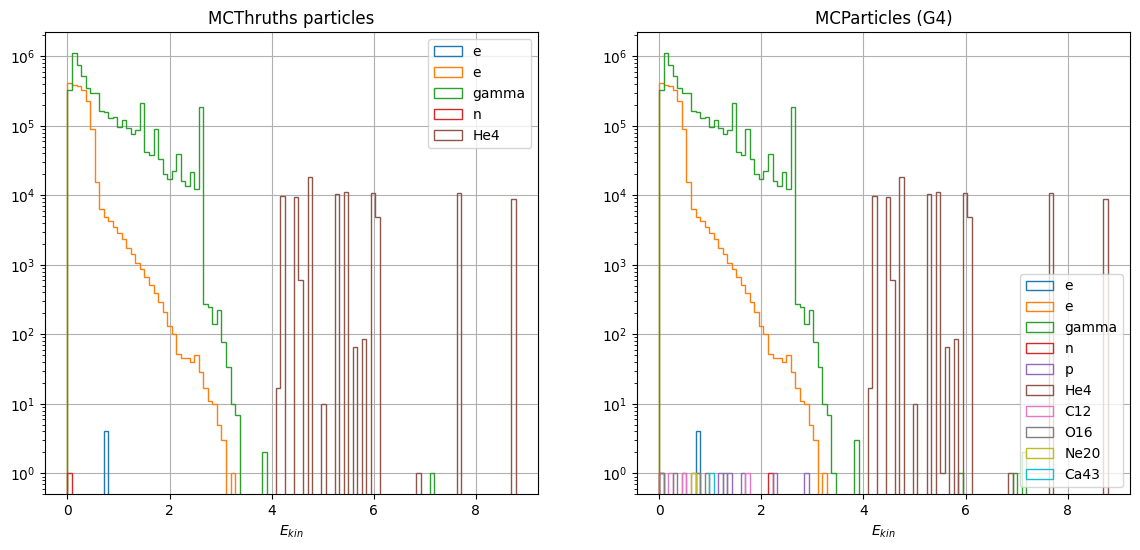

In [9]:
import particle

mct = datasets['radiols'].mctruths
mcp = datasets['radiols'].mcparticles
max_ke=max(mct.kinetic_energy.max(), mcp.kinetic_energy.max())

all_pdgs = np.union1d(mct.pdg.unique(), mcp.pdg.unique())
colors = plt.cm.tab10.colors 
color_map = {pdg: colors[i % len(colors)] for i, pdg in enumerate(all_pdgs)}

bins=np.linspace(0,max_ke*1000,100)
fig,axes=plt.subplots(1,2, figsize=(14,6))

ax=axes[0]
for pdg_id, df in mct.groupby('pdg'):
    pp = particle.Particle.from_pdgid(pdg_id)
    (df.kinetic_energy*1000).hist(bins=bins, label=f"{pp.pdg_name}", histtype='step', color=color_map[pdg_id], ax=ax)

ax.legend()
ax.set_yscale('log')
ax.set_xlabel(r'$E_{kin}$')
ax.set_title('MCThruths particles')


ax=axes[1]
for pdg_id, df in mcp.groupby('pdg'):
    pp = particle.Particle.from_pdgid(pdg_id)
    (df.kinetic_energy*1000).hist(bins=bins, label=f"{pp.pdg_name}", histtype='step', color=color_map[pdg_id], ax=ax)

ax.legend()
ax.set_yscale('log')
ax.set_xlabel(r'$E_{kin}$')
ax.set_title('MCParticles (G4)')




Text(0.5, 1.0, 'MCThruths particles')

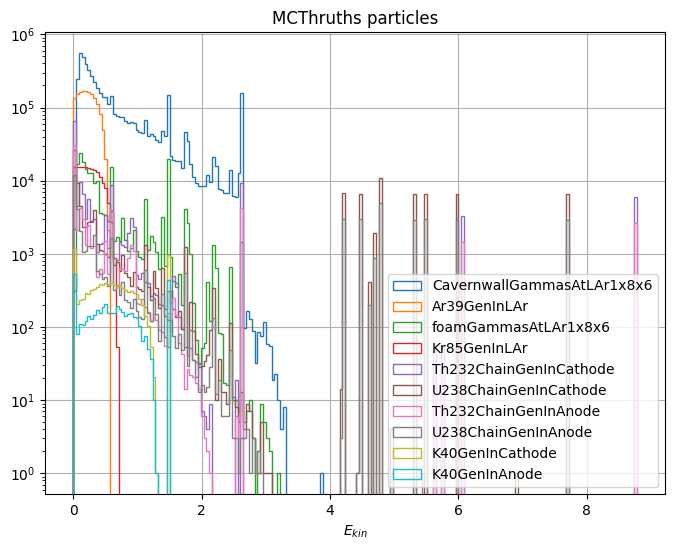

In [53]:

mct = datasets['radiols'].mctruths
max_ke=mct.kinetic_energy.max()

num_bkg=10
part_by_gen = sorted([(n,df) for n,df in mct.groupby('generator_name')], reverse=True, key=lambda x: len(x[1]))
top_by_gen = part_by_gen[:num_bkg]

all_gens = mct.generator_name.unique()
colors = plt.cm.tab10.colors 
color_map = {pdg: colors[i % len(colors)] for i, pdg in enumerate(all_gens)}

bins=np.linspace(0,max_ke*1000,200)
fig,axes=plt.subplots(1,1, figsize=(8,6))

ax=axes
# for gen_id, df in mct.groupby('generator_name'):
for gen_id, df in top_by_gen:

    # (df.kinetic_energy*1000).hist(bins=bins, label=f"{gen_id}", histtype='step', color=color_map[gen_id], ax=ax)
    (df.kinetic_energy*1000).hist(bins=bins, label=f"{gen_id}", histtype='step', ax=ax)

ax.legend()
ax.set_yscale('log')
ax.set_xlabel(r'$E_{kin}$')
ax.set_title('MCThruths particles')





/var/folders/dw/sj94s2457kl2gkb829ty4_cc0000gn/T/ipykernel_29615/2941591696.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')


[Text(0, 0, 'Rn222ChainBi214GenInLAr'),
 Text(1, 0, 'Rn222ChainFromBi214GenInUpperMesh1x8x6'),
 Text(2, 0, 'Th232ChainGenInAnode'),
 Text(3, 0, 'Rn222ChainFromPb210GenInUpperMesh1x8x6'),
 Text(4, 0, 'Rn222ChainFromPb214GenInUpperMesh1x8x6'),
 Text(5, 0, 'Rn222ChainPb214GenInLAr'),
 Text(6, 0, 'Ar39GenInLAr'),
 Text(7, 0, 'Rn222ChainPb210GenInLAr'),
 Text(8, 0, 'Rn222ChainFromBi210GenInUpperMesh1x8x6'),
 Text(9, 0, 'Ar42GenInLAr'),
 Text(10, 0, 'Rn220ChainPb212GenInLAr'),
 Text(11, 0, 'K40GenInAnode'),
 Text(12, 0, 'U238ChainGenInCathode'),
 Text(13, 0, 'Th232ChainGenInCathode'),
 Text(14, 0, 'K42From42ArGenInUpperMesh1x8x6'),
 Text(15, 0, 'K40GenInCathode'),
 Text(16, 0, 'U238ChainGenInAnode'),
 Text(17, 0, 'Kr85GenInLAr'),
 Text(18, 0, 'Rn220ChainFromPb212GenInUpperMesh1x8x6'),
 Text(19, 0, 'Rn222ChainGenInPDS'),
 Text(20, 0, 'K42From42ArGenInLAr')]

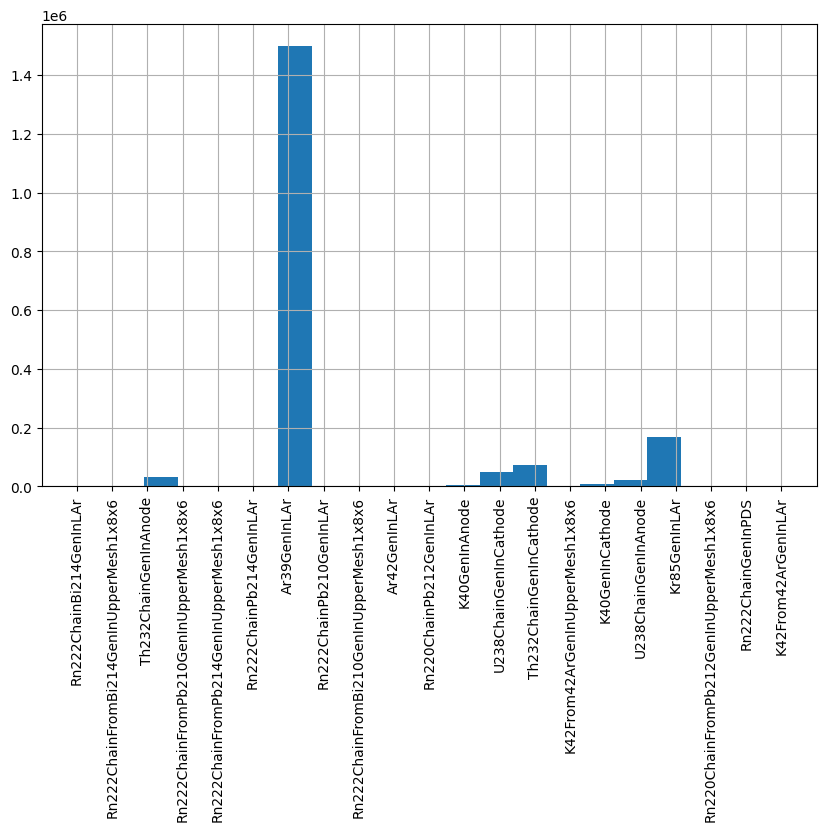

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
n_bins = datasets['radiols'].mctruths.query("pdg == 11").generator_name.nunique()
datasets['radiols'].mctruths.query("pdg == 11").generator_name.hist(bins=n_bins, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')



<Axes: >

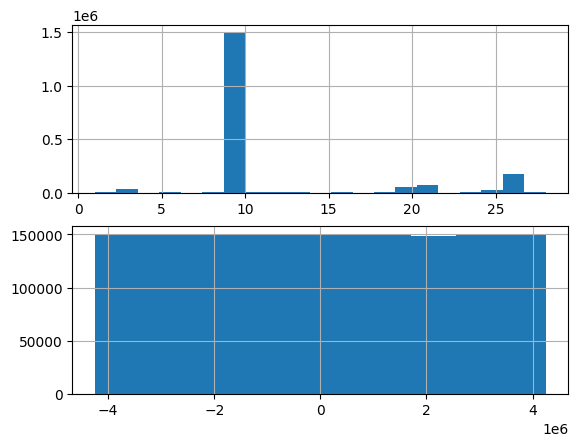

In [11]:
fig, axes = plt.subplots(2,1)
n_bins = datasets['radiols'].mcparticles.query("pdg == 11").truth_block_id.nunique()
datasets['radiols'].mcparticles.query("pdg == 11").truth_block_id.hist(bins=n_bins, ax=axes[0])


datasets['radiols'].mcparticles.query('truth_block_id == 9').t.hist(ax=axes[1])

In [12]:
datasets['radiols'].mctruth_blocks_map

{1: 'Rn222ChainBi214GenInLAr',
 2: 'Rn222ChainFromBi214GenInUpperMesh1x8x6',
 3: 'Th232ChainGenInAnode',
 4: 'CavernwallGammasAtLAr1x8x6',
 5: 'Rn222ChainFromPb210GenInUpperMesh1x8x6',
 6: 'Rn222ChainFromPb214GenInUpperMesh1x8x6',
 7: 'Rn222ChainPo218GenInLAr',
 8: 'Rn222ChainPb214GenInLAr',
 9: 'Ar39GenInLAr',
 10: 'Rn222ChainPb210GenInLAr',
 12: 'Rn222ChainFromBi210GenInUpperMesh1x8x6',
 13: 'Ar42GenInLAr',
 14: 'Rn222ChainGenInPDS',
 16: 'Rn220ChainPb212GenInLAr',
 18: 'K40GenInAnode',
 19: 'U238ChainGenInCathode',
 20: 'Rn222ChainRn222GenInLAr',
 21: 'Th232ChainGenInCathode',
 22: 'K42From42ArGenInUpperMesh1x8x6',
 23: 'foamGammasAtLAr1x8x6',
 24: 'K40GenInCathode',
 25: 'U238ChainGenInAnode',
 26: 'Kr85GenInLAr',
 28: 'Rn220ChainFromPb212GenInUpperMesh1x8x6',
 11: 'Rn222ChainFromPo218GenInUpperMesh1x8x6',
 0: 'CavernNGammasAtLAr1x8x6',
 15: 'K42From42ArGenInLAr',
 17: 'CavernwallNeutronsAtLAr1x8x6',
 27: 'CryostatNGammasAtLAr1x8x6'}

# TP Rates

## Per detector channel

For comparison with HD

In [13]:
fmts={
    'U':'{:.2f} Hz',
    'V':'{:.2f} Hz',
    'X':'{:.2f} Hz',
    'time':'{:.3f} s',
    }
print(df_to_table(make_rates_table_from_workspaces(datasets, f'bt_is_signal == 0', per='chan'),formatters=fmts, title='noise TP rates'))
print(df_to_table(make_rates_table_from_workspaces(datasets, f'bt_is_signal == 1', per='chan'),formatters=fmts, title='physics TP rates'))

AttributeError: 'TriggerPrimitivesWorkspace' object has no attribute '_info_extra'

## Per CRP

For comparison with HD. Each CRP observes a LAr volume equivalent to an APA

In [ ]:
print(df_to_table(make_rates_table_from_workspaces(datasets, f'bt_is_signal == 0', per='crp'),formatters=fmts, title='noise TP rates'))
print(df_to_table(make_rates_table_from_workspaces(datasets, f'bt_is_signal == 1', per='crp'),formatters=fmts, title='physics TP rates'))

                          noise TP rates                           
┏━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃   ┃ dataset  ┃ time    ┃ U           ┃ V           ┃ X          ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ 0 │ e-minus  │ 0.400 s │ 841.04 Hz   │ 818.33 Hz   │ 351.67 Hz  │
│ 1 │ gamma    │ 0.400 s │ 846.67 Hz   │ 823.12 Hz   │ 345.62 Hz  │
│ 2 │ mu-minus │ 0.400 s │ 817.50 Hz   │ 829.58 Hz   │ 368.54 Hz  │
│ 3 │ ar39     │ 0.400 s │ 1073.75 Hz  │ 2486.67 Hz  │ 486.67 Hz  │
│ 4 │ radiols  │ 0.400 s │ 11227.29 Hz │ 16702.50 Hz │ 4637.29 Hz │
└───┴──────────┴─────────┴─────────────┴─────────────┴────────────┘

                          physics TP rates                          
┏━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃   ┃ dataset  ┃ time    ┃ U           ┃ V           ┃ X           ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ 0 │ e-minus  │ 0.400 s │ 477.08 Hz   │ 438.54 Hz   │ 553.54 Hz   │
│ 1 │ gamma    │ 0.400 s │ 417.50 Hz   │ 397.29 Hz   │ 503.96 Hz   │
│ 2 │ mu-minus │ 0.400 s │ 379.17 Hz   │ 380.42 Hz   │ 456.04 Hz   │
│ 3 │ ar39     │ 0.400 s │ 23852.50 Hz │ 11529.79 Hz │ 38512.29 Hz │
│ 4 │ radiols  │ 0.400 s │ 62120.21 Hz │ 36684.17 Hz │ 89534.79 Hz │
└───┴──────────┴─────────┴─────────────┴─────────────┴─────────────┘

## Per CRP with SOT cut

As before, after including the `samples_over_threshold > 8` for rejection of Ar39 signals

In [ ]:
print('samples_over_threshold > 7')
print(df_to_table(make_rates_table_from_workspaces(datasets, 'bt_is_signal == 0 & samples_over_threshold > 7', per='crp'),formatters=fmts, title='noise TP rates'))
print(df_to_table(make_rates_table_from_workspaces(datasets, 'bt_is_signal == 1 & samples_over_threshold > 7', per='crp'),formatters=fmts, title='physics TP rates'))

print('samples_over_threshold > 8')
print(df_to_table(make_rates_table_from_workspaces(datasets, 'bt_is_signal == 0 & samples_over_threshold > 8', per='crp'),formatters=fmts, title='noise TP rates'))
print(df_to_table(make_rates_table_from_workspaces(datasets, 'bt_is_signal == 1 & samples_over_threshold > 8', per='crp'),formatters=fmts, title='physics TP rates'))

samples_over_threshold > 7

                       noise TP rates                       
┏━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┓
┃   ┃ dataset  ┃ time    ┃ U         ┃ V         ┃ X       ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━┩
│ 0 │ e-minus  │ 0.400 s │ 1.25 Hz   │ 2.71 Hz   │ 0.00 Hz │
│ 1 │ gamma    │ 0.400 s │ 0.42 Hz   │ 2.08 Hz   │ 0.00 Hz │
│ 2 │ mu-minus │ 0.400 s │ 1.46 Hz   │ 1.46 Hz   │ 0.00 Hz │
│ 3 │ ar39     │ 0.400 s │ 0.00 Hz   │ 0.00 Hz   │ 0.00 Hz │
│ 4 │ radiols  │ 0.400 s │ 161.46 Hz │ 828.33 Hz │ 1.04 Hz │
└───┴──────────┴─────────┴───────────┴───────────┴─────────┘

                         physics TP rates                          
┏━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃   ┃ dataset  ┃ time    ┃ U          ┃ V           ┃ X           ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ 0 │ e-minus  │ 0.400 s │ 328.13 Hz  │ 342.50 Hz   │ 448.33 Hz   │
│ 1 │ gamma    │ 0.400 s │ 281.46 Hz  │ 311.04 Hz   │ 406.04 Hz   │
│ 2 │ mu-minus │ 0.400 s │ 241.67 Hz  │ 294.17 Hz   │ 357.71 Hz   │
│ 3 │ ar39     │ 0.400 s │ 0.00 Hz    │ 256.88 Hz   │ 3358.33 Hz  │
│ 4 │ radiols  │ 0.400 s │ 3000.21 Hz │ 15589.17 Hz │ 24417.92 Hz │
└───┴──────────┴─────────┴────────────┴─────────────┴─────────────┘

samples_over_threshold > 8

                      noise TP rates                       
┏━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┓
┃   ┃ dataset  ┃ time    ┃ U        ┃ V         ┃ X       ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━┩
│ 0 │ e-minus  │ 0.400 s │ 0.42 Hz  │ 1.67 Hz   │ 0.00 Hz │
│ 1 │ gamma    │ 0.400 s │ 0.42 Hz  │ 1.67 Hz   │ 0.00 Hz │
│ 2 │ mu-minus │ 0.400 s │ 0.83 Hz  │ 1.04 Hz   │ 0.00 Hz │
│ 3 │ ar39     │ 0.400 s │ 0.00 Hz  │ 0.00 Hz   │ 0.00 Hz │
│ 4 │ radiols  │ 0.400 s │ 22.29 Hz │ 314.58 Hz │ 0.42 Hz │
└───┴──────────┴─────────┴──────────┴───────────┴─────────┘

                         physics TP rates                         
┏━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃   ┃ dataset  ┃ time    ┃ U         ┃ V           ┃ X           ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ 0 │ e-minus  │ 0.400 s │ 286.04 Hz │ 323.13 Hz   │ 435.62 Hz   │
│ 1 │ gamma    │ 0.400 s │ 250.21 Hz │ 293.96 Hz   │ 392.92 Hz   │
│ 2 │ mu-minus │ 0.400 s │ 216.04 Hz │ 277.71 Hz   │ 341.46 Hz   │
│ 3 │ ar39     │ 0.400 s │ 0.00 Hz   │ 55.83 Hz    │ 633.54 Hz   │
│ 4 │ radiols  │ 0.400 s │ 971.04 Hz │ 12745.00 Hz │ 16162.71 Hz │
└───┴──────────┴─────────┴───────────┴─────────────┴─────────────┘

# Background rates and spectra per radiological process

In [19]:
# Create a TP preselection - only TPs with peak within the range where backtracking works

rad_sel = snn.TPSignalNoiseSelector(rad_ws.tps)

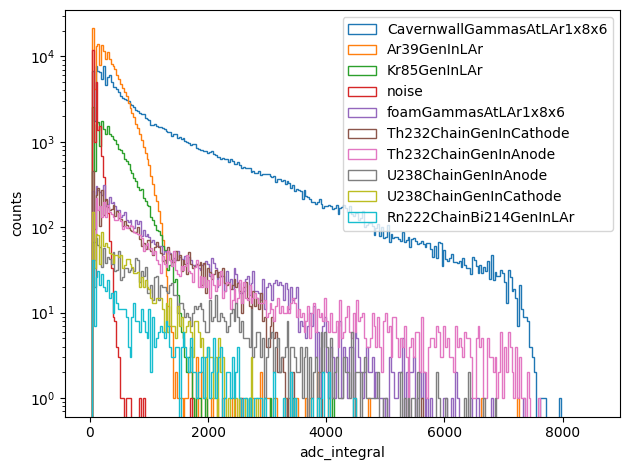

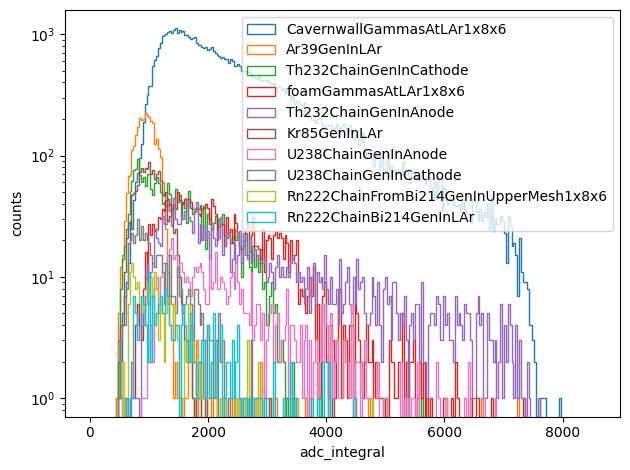

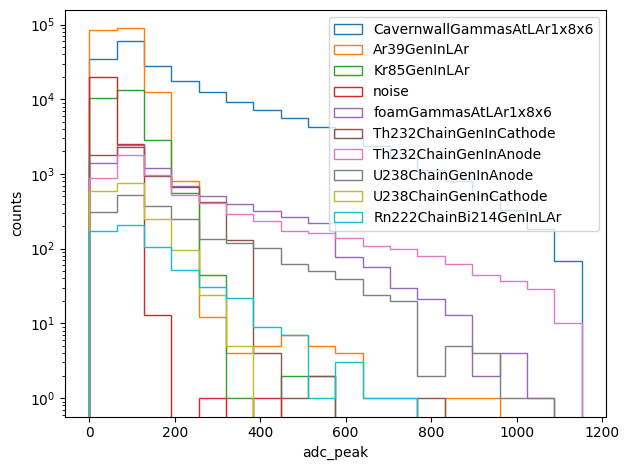

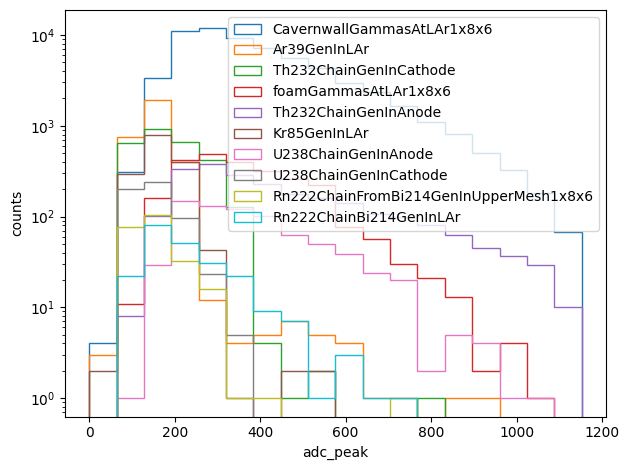

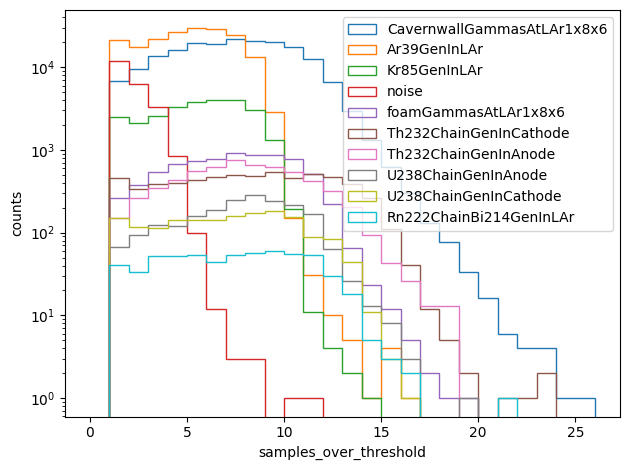

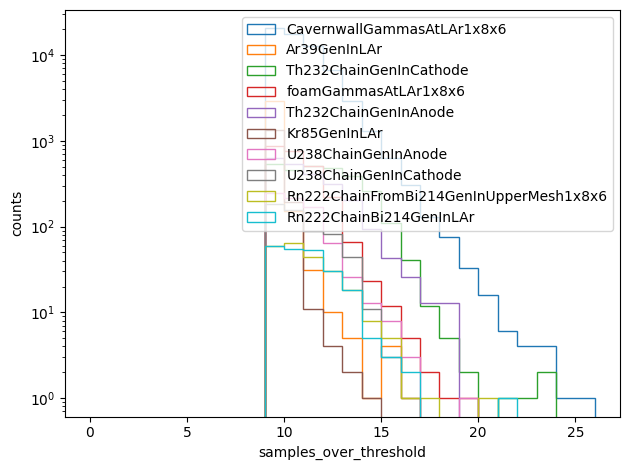

In [46]:
# Plot rates distributions for the top backgrounds

def plot_tpcounts_by_source(tps, var='adc_integral', binsize=8):

    num_bkg = 10
    tps_by_gen = sorted([(n,df) for n,df in tps.groupby('bt_generator_name')], reverse=True, key=lambda x: len(x[1]))
    top_by_gen = tps_by_gen[:num_bkg]

    bin_max = max([df[var].max() for _, df in top_by_gen])

    bins=np.arange(0, int(bin_max), binsize)

    fig, ax = plt.subplots()
    # fig, ax = plt.subplots(figsize=(12,10))
    for n,df in top_by_gen:
        ax.hist(df[var], bins=bins, histtype='step', label=n if n else 'noise')
    ax.legend()
    ax.set_yscale('log')
    ax.set_xlabel(var)
    ax.set_ylabel('counts')
    fig.tight_layout()
    return fig

ro_view = 2
var = 'adc_integral'
fig = plot_tpcounts_by_source(rad_sel.all_by_view[ro_view], var=var, binsize=32)
fig = plot_tpcounts_by_source(rad_sel.all_by_view[ro_view].query('samples_over_threshold > 8'), var=var, binsize=32)
var = 'adc_peak'
fig = plot_tpcounts_by_source(rad_sel.all_by_view[ro_view], var=var, binsize=64)
fig = plot_tpcounts_by_source(rad_sel.all_by_view[ro_view].query('samples_over_threshold > 8'), var=var, binsize=64)
var = 'samples_over_threshold'
fig = plot_tpcounts_by_source(rad_sel.all_by_view[ro_view], var=var, binsize=1)
fig = plot_tpcounts_by_source(rad_sel.all_by_view[ro_view].query('samples_over_threshold > 8'), var=var, binsize=1)


## Rates per background process process

In [15]:
# Split the background sample by generator name, into a collection of dataframes
rad_tps_by_gen = sorted([(n if n else 'Noise',df) for n,df in rad_sel.all.groupby('bt_generator_name')], reverse=True, key=lambda x: len(x[1]))

NameError: name 'rad_sel' is not defined

In [16]:
# Print rates of each background by readout view
# Without cuts and applying the SOT cut to reject Ar39
print(make_vd_rates_table_2(OrderedDict(rad_tps_by_gen), 100, per='crp', title='Rates per CRP'))
print(make_vd_rates_table_2(OrderedDict(rad_tps_by_gen), 100, 'samples_over_threshold>8', per='crp', title='Rates per CRP (SOT > 7)'))

NameError: name 'rad_tps_by_gen' is not defined

# TP properties in signal samples

In [17]:

dataset_psel = {
    n: snn.TPSignalNoiseSelector(df.tps) for n, df in datasets.items()
}

(0.0, 25.0)

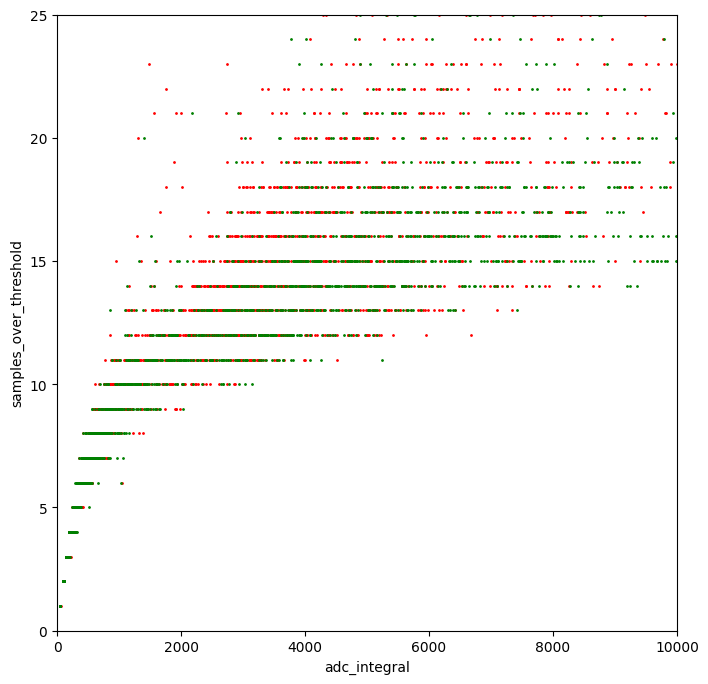

In [18]:
fix, ax = plt.subplots(figsize=(8,8))

size=1
x_name='adc_integral'
dataset_psel['e-minus'].sig_view_2.plot.scatter(x=x_name, y='samples_over_threshold', s=size, ax=ax, c='red')
dataset_psel['mu-minus'].sig_view_2.plot.scatter(x=x_name, y='samples_over_threshold', s=size, ax=ax, c='green')
# dataset_psel['gamma'].sig_view_2.plot.scatter(x=x_name, y='samples_over_threshold', s=size, ax=ax, c='orange')
# dataset_psel['radiols'].sig_view_2.query('bt_generator_name != "Ar39GenInLAr"').plot.scatter(x=x_name, y='samples_over_threshold', alpha=size, s=0.1, ax=ax, c='green')
# dataset_psel['radiols'].sig_view_2.query('bt_generator_name == "Ar39GenInLAr"').plot.scatter(x=x_name, y='samples_over_threshold', alpha=size, s=0.1, ax=ax, c='blue')


ax.set_xlim(left=0, right=10000)
ax.set_ylim(bottom=0, top=25)



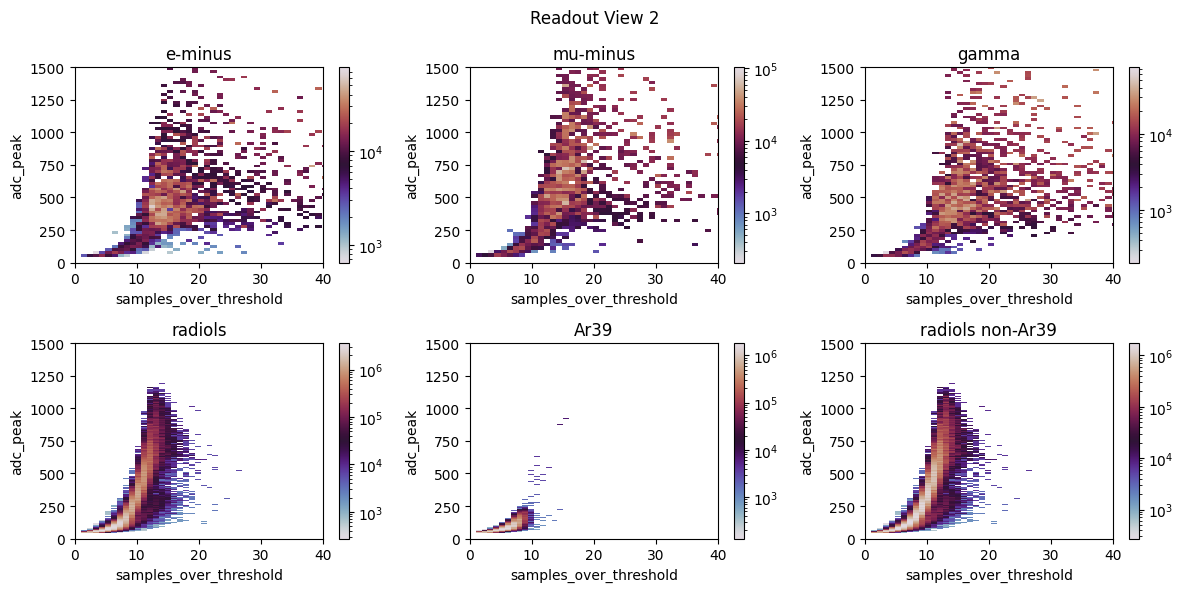

In [18]:
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(2,3, figsize=(12,6))

size=1
x_name='samples_over_threshold'
x_range  = 0,40
y_name='adc_peak'
y_range  = 0,1500
cmap='twilight'
weights = 'adc_integral'
cut=''
v = 2


def plot_me(ax, sample, sample_query: str = None, title: str = None):
    """
    Helper function
    """
    df = dataset_psel[sample].sig_by_view[v]
    title = title if title else sample
    
    # Trim the dataframe
    for c in [sample_query, cut]:
        df = df.query(c) if c else df

    # apply weigths
    w = df[weights] if weights else None

    # Bin 
    bins=(df[x_name].max(), 200)
    h = ax.hist2d(df[x_name], df[y_name], bins=bins, cmap=cmap, weights=w, norm=LogNorm())

    fig.colorbar(h[3], ax=ax)

    ax.set_title(title)
    ax.set_ylim(y_range)
    ax.set_ylabel(y_name)
    ax.set_xlim(x_range)
    ax.set_xlabel(x_name)

plot_me(axes[0][0], 'e-minus')
plot_me(axes[0][1], 'mu-minus')
plot_me(axes[0][2], 'gamma')
plot_me(axes[1][0], 'radiols')
plot_me(axes[1][1], 'radiols', 'bt_generator_name == "Ar39GenInLAr"', title='Ar39')
plot_me(axes[1][2], 'radiols', 'bt_generator_name != "Ar39GenInLAr"', 'radiols non-Ar39')

# ----
# remove the underlying axes
# axes[1,2].remove()

fig.suptitle(f"Readout View {v}")
fig.tight_layout()
# fig.show()





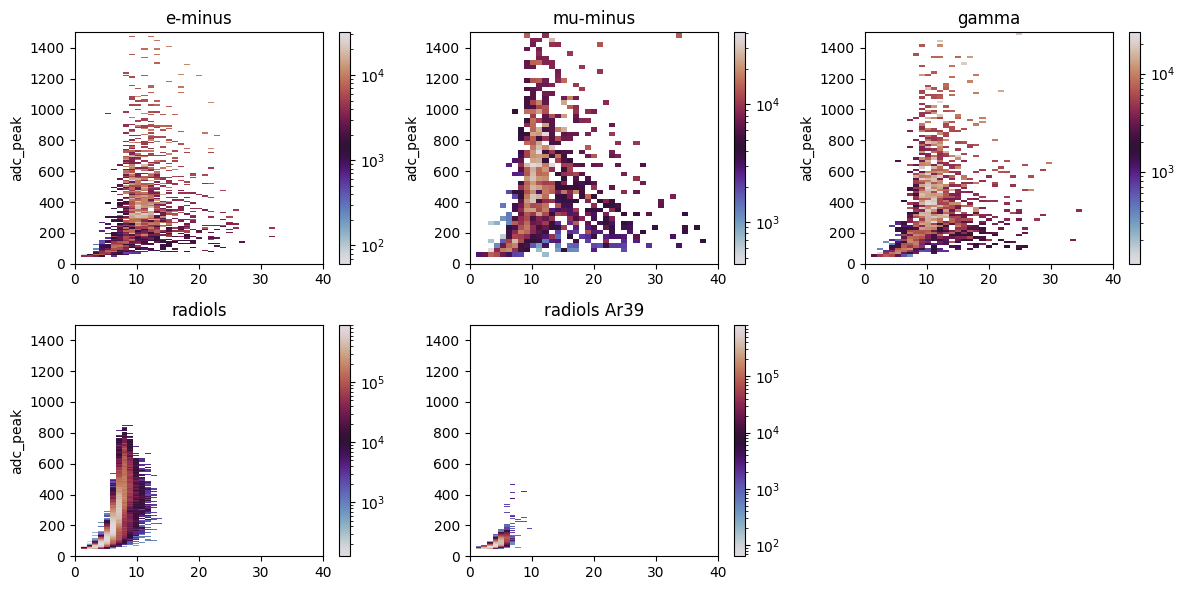

In [19]:
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(2,3, figsize=(12,6))

size=1
x_name='samples_over_threshold'
x_range  = 0,40
y_name='adc_peak'
y_range  = 0,1500
cmap='twilight'
weights = 'adc_integral'
cut=''
v = 0

# dataset_psel['e-minus'].sig_view_2.plot.scatter(x=x_name, y='samples_over_threshold', s=size, ax=ax, c='red')
# dataset_psel['mu-minus'].sig_view_2.plot.scatter(x=x_name, y='samples_over_threshold', s=size, ax=ax, c='green')
# dataset_psel['gamma'].sig_view_2.plot.scatter(x=x_name, y='samples_over_threshold', s=size, ax=ax, c='orange')
# dataset_psel['radiols'].sig_view_2.query('bt_generator_name != "Ar39GenInLAr"').plot.scatter(x=x_name, y='samples_over_threshold', alpha=size, s=0.1, ax=ax, c='green')
# dataset_psel['radiols'].sig_view_2.query('bt_generator_name == "Ar39GenInLAr"').plot.scatter(x=x_name, y='samples_over_threshold', alpha=size, s=0.1, ax=ax, c='blue')


# ----
sample='e-minus'
ax = axes[0][0]
df = dataset_psel[sample].sig_by_view[v]
df = df.query(cut) if cut else df
w = df[weights] if weights else None

bins=(df[x_name].max(), 200)
h = ax.hist2d(df[x_name], df[y_name], bins=bins, cmap=cmap, weights=w, norm=LogNorm())

fig.colorbar(h[3], ax=ax)

ax.set_title(sample)
ax.set_ylim(y_range)
ax.set_ylabel(y_name)
ax.set_xlim(x_range)

# ----
sample='mu-minus'
ax = axes[0][1]
df = dataset_psel[sample].sig_by_view[v]
df = df.query(cut) if cut else df
w = df[weights] if weights else None

bins=(df[x_name].max(), 200)
h = ax.hist2d(df[x_name], df[y_name], bins=bins, cmap=cmap, weights=w, norm=LogNorm())

fig.colorbar(h[3], ax=ax)

ax.set_title(sample)
ax.set_ylim(y_range)
ax.set_ylabel(y_name)
ax.set_xlim(x_range)

# ----
sample='gamma'
ax = axes[0][2]
df = dataset_psel['gamma'].sig_by_view[v]
df = df.query(cut) if cut else df
w = df[weights] if weights else None

bins=(df[x_name].max(), 200)
h = ax.hist2d(df[x_name], df[y_name], bins=bins, cmap=cmap, weights=w, norm=LogNorm())

fig.colorbar(h[3], ax=ax)

ax.set_title(sample)
ax.set_ylim(y_range)
ax.set_ylabel(y_name)
ax.set_xlim(x_range)

# ----
sample='radiols'
ax = axes[1][0]
df = dataset_psel[sample].query('bt_generator_name != "Ar39GenInLAr"').sig_by_view[v]
df = df.query(cut) if cut else df
w = df[weights] if weights else None

bins=(df[x_name].max(), 200)
h = ax.hist2d(df[x_name], df[y_name], bins=bins, cmap=cmap, weights=w, norm=LogNorm())

fig.colorbar(h[3], ax=ax)

ax.set_title(sample)
ax.set_ylim(y_range)
ax.set_ylabel(y_name)
ax.set_xlim(x_range)

# ----
sample='radiols'
ax = axes[1][1]
df = dataset_psel[sample].query('bt_generator_name == "Ar39GenInLAr"').sig_by_view[v]
df = df.query(cut) if cut else df
w = df[weights] if weights else None

bins=(df[x_name].max(), 200)
h = ax.hist2d(df[x_name], df[y_name], bins=bins, cmap=cmap, weights=w, norm=LogNorm())

fig.colorbar(h[3], ax=ax)

ax.set_title(sample+' Ar39')
ax.set_ylim(y_range)
ax.set_xlim(x_range)

# ----
# remove the underlying axes
axes[1,2].remove()

fig.tight_layout()
# fig.show()





# Impact of Ar39 rejection cut on single particles and radiologicals

In tems of number of TPs and collected charge (`adc_integral`)

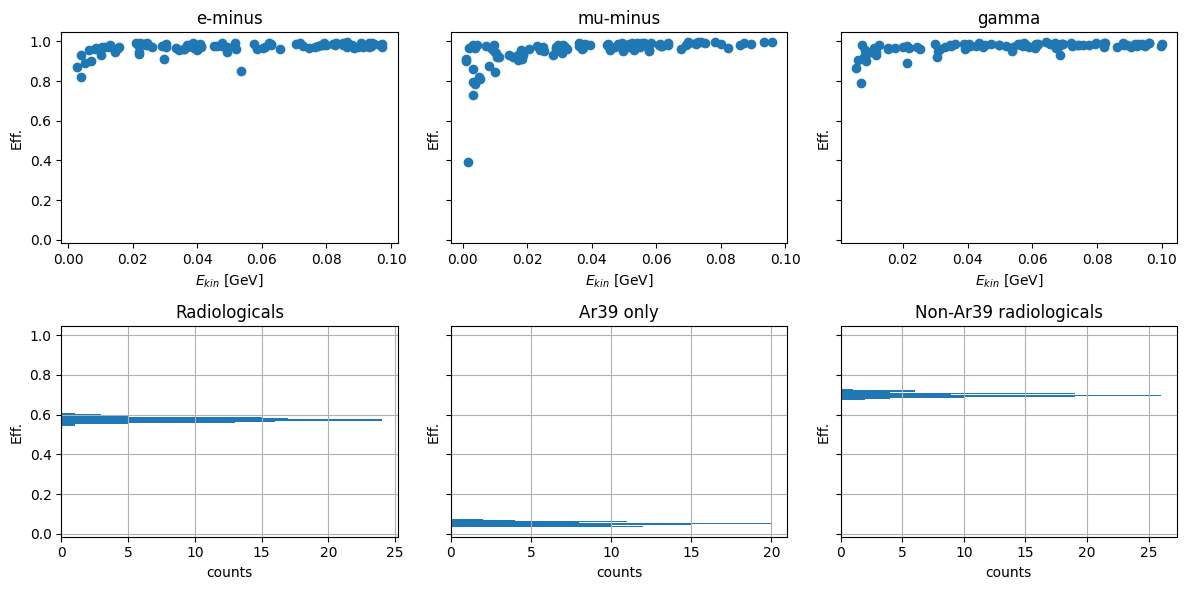

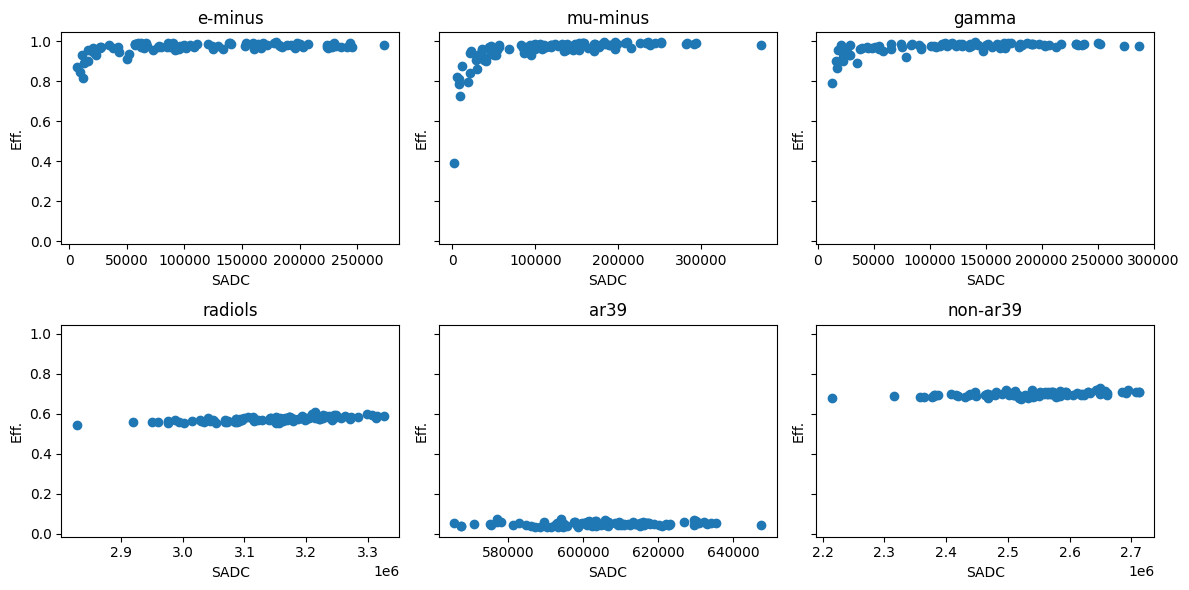

In [20]:
# Copy dataset_psel and add ar39 and non-ar39 rads
dss = dataset_psel.copy()
dss['ar39'] = dss['radiols'].query('bt_generator_name == "Ar39GenInLAr"')
dss['non-ar39'] = dss['radiols'].query('bt_generator_name != "Ar39GenInLAr"')


fig, axes = plt.subplots(2,3, figsize=(12,6), sharey=True)

sample='e-minus'
cut='samples_over_threshold>8'
v=2

def plot_ratio_ekin(ax, sample):
    
    ds = dataset_psel[sample]
    sum_adc_total = (ds.all_by_view[v].groupby(['event']).adc_integral.sum())
    sum_adc_filtered = (ds.query(cut).all_by_view[v].groupby(['event']).adc_integral.sum())

    ek = datasets[sample].mctruths.kinetic_energy

    ax.scatter(x=ek, y=sum_adc_filtered/sum_adc_total)
    ax.set_title(sample)
    ax.set_ylabel("Eff.")
    ax.set_xlabel("$E_{kin}$ [GeV]")


def plot_eff_hist():
    pass

def plot_ratio_sadc(ax, sample):
    ds = dss[sample]
    sum_adc_total = (ds.all_by_view[v].groupby(['event']).adc_integral.sum())
    sum_adc_filtered = (ds.query(cut).all_by_view[v].groupby(['event']).adc_integral.sum())

    ax.scatter(x=sum_adc_total, y=sum_adc_filtered/sum_adc_total)
    ax.set_title(sample)
    ax.set_ylabel("Eff.")
    ax.set_xlabel("SADC")

plot_ratio_ekin(axes[0,0],'e-minus')
plot_ratio_ekin(axes[0,1],'mu-minus')
plot_ratio_ekin(axes[0,2],'gamma')
# plot_me(axes[1,0],'radiols')

#---
ax=axes[1,0]
sample='radiols'
ds = dataset_psel[sample]

sum_adc_total = (ds.all_by_view[v].groupby(['event']).adc_integral.sum())
y = (ds.query(cut).all_by_view[v].groupby(['event']).adc_integral.sum())
(y/sum_adc_total).hist(ax=ax, orientation="horizontal")
ax.set_title("Radiologicals")
ax.set_xlabel("counts")
ax.set_ylabel("Eff.")


#---
ax=axes[1,1]
sample='radiols'
ds = dataset_psel[sample].query('bt_generator_name == "Ar39GenInLAr"')

sum_adc_total = (ds.all_by_view[v].groupby(['event']).adc_integral.sum())
y = (ds.query(cut).all_by_view[v].groupby(['event']).adc_integral.sum())
(y/sum_adc_total).hist(ax=ax,orientation="horizontal")
ax.set_title("Ar39 only")
ax.set_xlabel("counts")
ax.set_ylabel("Eff.")

#---
ax=axes[1,2]
sample='radiols'
ds = dataset_psel[sample].query('bt_generator_name != "Ar39GenInLAr"')

sum_adc_total = (ds.all_by_view[v].groupby(['event']).adc_integral.sum())
y = (ds.query(cut).all_by_view[v].groupby(['event']).adc_integral.sum())
(y/sum_adc_total).hist(ax=ax, orientation="horizontal")
ax.set_title("Non-Ar39 radiologicals")
ax.set_xlabel("counts")
ax.set_ylabel("Eff.")

# axes[1,1].remove()
# axes[1,2].remove()


fig.tight_layout()


fig, axes = plt.subplots(2,3, figsize=(12,6), sharey=True)
plot_ratio_sadc(axes[0,0],'e-minus')
plot_ratio_sadc(axes[0,1],'mu-minus')
plot_ratio_sadc(axes[0,2],'gamma')
plot_ratio_sadc(axes[1,0],'radiols')
plot_ratio_sadc(axes[1,1],'ar39')
plot_ratio_sadc(axes[1,2],'non-ar39')
fig.tight_layout()


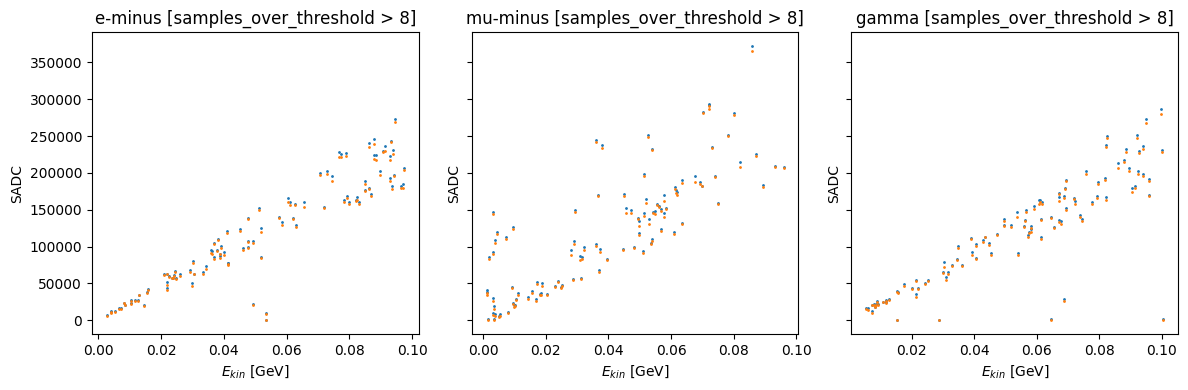

In [21]:
# Copy dataset_psel and add ar39 and non-ar39 rads
dss = dataset_psel.copy()
dss['ar39'] = dss['radiols'].query('bt_generator_name == "Ar39GenInLAr"')
dss['non-ar39'] = dss['radiols'].query('bt_generator_name != "Ar39GenInLAr"')


fig, axes = plt.subplots(1,3, figsize=(12,4), sharey=True,squeeze=False)

sample='e-minus'
cut='samples_over_threshold>8'
v=2

def plot_adcint_ekin(ax, sample, cut: str=None):
    
    ds = dataset_psel[sample]
    if cut:
        ds=ds.query(cut)
    adcint_ev = (ds.all_by_view[v].groupby(['event']).adc_integral.sum())
    # print("adcint>>\n", adcint_ev)
    # print("adcint>>\n", adcint_ev.to_frame())
    # print(len(datasets[sample].mctruths))
    # print(len(datasets[sample].mctruths.event))

    # ek = datasets[sample].mctruths.kinetic_energy
    df = datasets[sample].mctruths[['event', 'kinetic_energy']]
    df = df.join(adcint_ev.to_frame(), on='event', how='outer').fillna(0)
    # print("c\n\n",c)
    ax.scatter(x=df.kinetic_energy, y=df.adc_integral, s=1)
    ax.set_title(sample + (f' [{cut}]' if cut else ''))
    ax.set_ylabel("SADC")
    ax.set_xlabel("$E_{kin}$ [GeV]")


plot_adcint_ekin(axes[0,0], 'e-minus')
plot_adcint_ekin(axes[0,1], 'mu-minus')
plot_adcint_ekin(axes[0,2], 'gamma')


plot_adcint_ekin(axes[0,0], 'e-minus', cut='samples_over_threshold > 8')
plot_adcint_ekin(axes[0,1], 'mu-minus', cut='samples_over_threshold > 8')
plot_adcint_ekin(axes[0,2], 'gamma', cut='samples_over_threshold > 8')
fig.tight_layout()

AOC (background rejection vs signal efficiency) = 0.9552

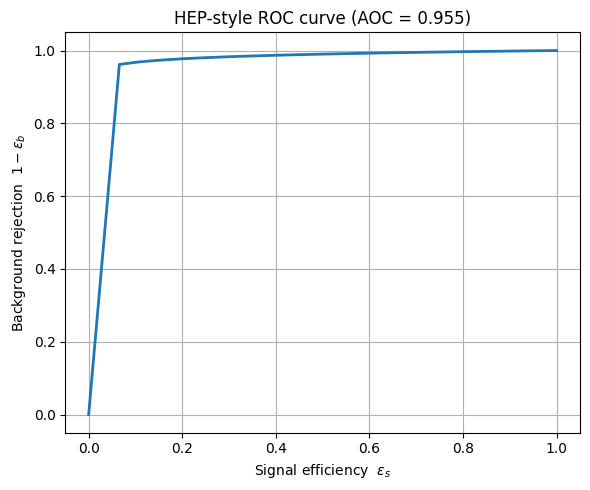

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Example data (replace with your real pandas Series)
# Suppose these correspond to progressively tighter cuts
# ------------------------------------------------------------
cuts = np.linspace(0, 1, 50)

# Fake efficiencies
sig_eff_series = pd.Series(cuts**0.7)    # signal efficiency ε_s
bkg_eff_series = pd.Series(cuts**0.01)    # background rejection 1 - ε_b

# ------------------------------------------------------------
# Prepare the curve
# ------------------------------------------------------------
sig_eff = sig_eff_series.values      # x-axis
bkg_rej = bkg_eff_series.values      # y-axis

# Ensure the x-axis is sorted (important for integration)
order = np.argsort(sig_eff)
x = sig_eff[order]
y = bkg_rej[order]

# ------------------------------------------------------------
# Compute the AOC (area under the HEP-style curve)
# ------------------------------------------------------------
aoc = np.trapezoid(y, x)
print(f"AOC (background rejection vs signal efficiency) = {aoc:.4f}")

# ------------------------------------------------------------
# Plot the HEP-style curve
# ------------------------------------------------------------
plt.figure(figsize=(6,5))
plt.plot(x, y, lw=2)
plt.xlabel(r"Signal efficiency  $\epsilon_s$")
plt.ylabel(r"Background rejection  $1 - \epsilon_b$")
plt.title(f"HEP-style ROC curve (AOC = {aoc:.3f})")
plt.grid(True)
plt.tight_layout()
plt.show()


## ROCs and AOCs

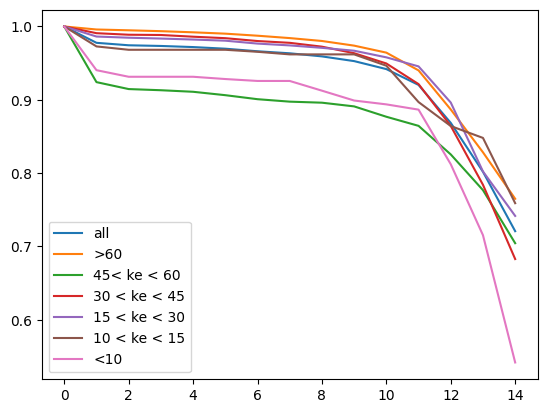

In [23]:
sot_cuts = list(range(15))


# Define main signal tp dataset
coll_tps = dataset_psel['e-minus'].all_by_view[2]

metric = lambda x: len(x)
metric = lambda x: x.adc_integral.sum()

ev_df = coll_tps.extra_info['event_list'][['event']].copy()

num_tps = pd.DataFrame([(ev, metric(df)) for ev, df in coll_tps.groupby('event')], columns=['event','num_tps'], dtype=int)

counts_df = ev_df.merge(num_tps, on="event", how="left")

for t in sot_cuts:
    cut = f"samples_over_threshold > {t}"
    # num_tps = pd.DataFrame([(ev, len(df)) for ev, df in coll_tps.query(cut).groupby('event')], columns=['event',t], dtype=int)
    num_tps = pd.DataFrame([(ev, metric(df)) for ev, df in coll_tps.query(cut).groupby('event')], columns=['event',t], dtype=int)
    counts_df = counts_df.merge(num_tps, on="event", how="left")

counts_df.fillna(0, inplace=True)

eff_df = ev_df.copy()
for t in sot_cuts:
    eff_df[t] = counts_df[t]/counts_df['num_tps']

#------

# extract the event kinetic energy 
ekin = datasets['e-minus'].mctruths[['event','kinetic_energy']].copy()
ekin['kinetic_energy'] = ekin['kinetic_energy']*1000

eff_df_ke = eff_df.merge(ekin, on="event", how="left")


fig, axes = plt.subplots()
ax=axes
eff_df_ke[sot_cuts].mean().plot(ax=ax, label='all')
eff_df_ke.query('kinetic_energy > 60')[sot_cuts].mean().plot(ax=ax, label='>60')
eff_df_ke.query('(kinetic_energy > 45) & (kinetic_energy <= 60)')[sot_cuts].mean().plot(ax=ax, label='45< ke < 60')
eff_df_ke.query('(kinetic_energy > 30) & (kinetic_energy <= 45)')[sot_cuts].mean().plot(ax=ax, label='30 < ke < 45')
eff_df_ke.query('(kinetic_energy > 15) & (kinetic_energy <= 30)')[sot_cuts].mean().plot(ax=ax, label='15 < ke < 30')
eff_df_ke.query('(kinetic_energy > 10) & (kinetic_energy <= 15)')[sot_cuts].mean().plot(ax=ax, label='10 < ke < 15')
eff_df_ke.query('kinetic_energy <= 10')[sot_cuts].mean().plot(ax=ax, label='<10')

plt.legend()


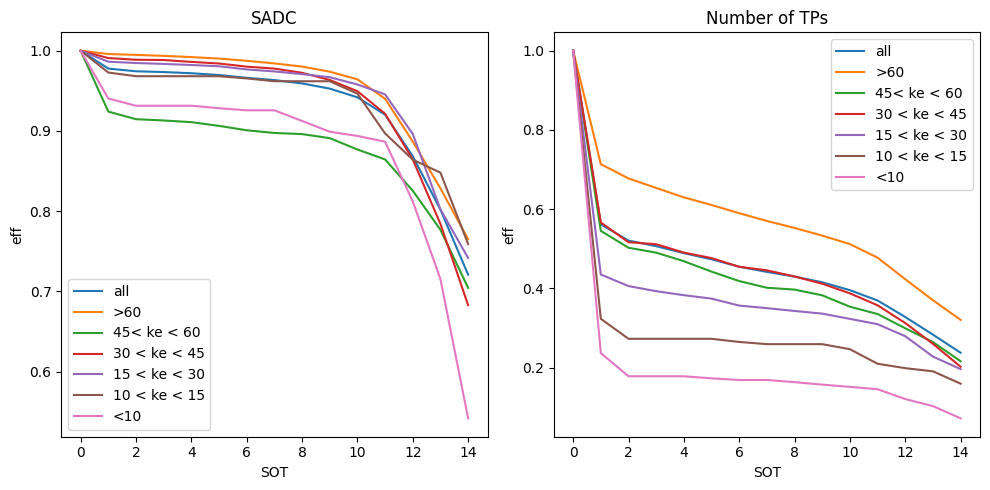

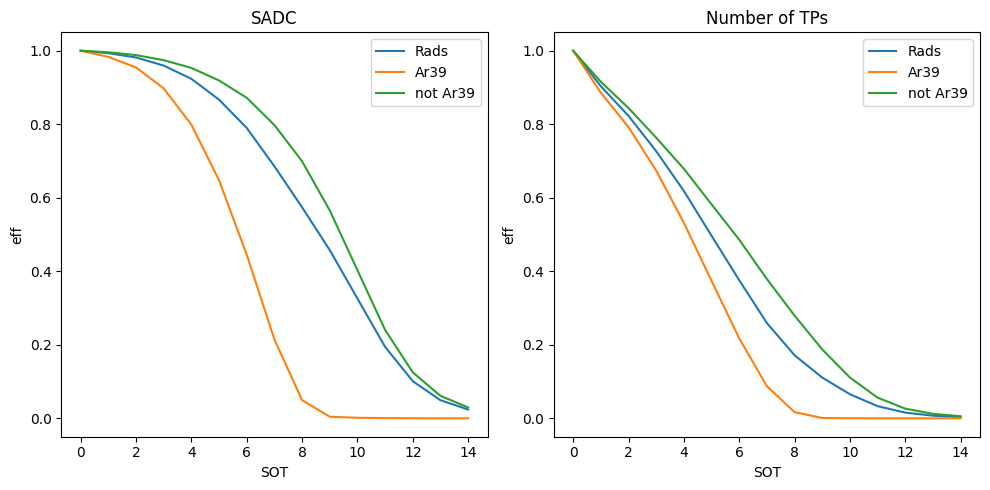

In [24]:
sot_cuts = list(range(15))


# Define main signal tp dataset
em_coll_tps = dss['e-minus'].all_by_view[2]
rad_coll_tps = dss['radiols'].all_by_view[2]
ar39_coll_tps = dss['ar39'].all_by_view[2]
nar39_coll_tps = dss['non-ar39'].all_by_view[2]


def calculate_cut_eff_by_event(tpd_df: workspace.TPDataFrame, cutvar='samples_over_threshold', metric:str='counts') -> workspace.TPDataFrame:

    match metric:
        case 'counts':
            metric = lambda x: len(x)
        case 'adc_int':
            metric = lambda x: x.adc_integral.sum()
        case _:
            return None

    ev_df = tpd_df.extra_info['event_list'][['event']].copy()

    num_tps = pd.DataFrame([(ev, metric(df)) for ev, df in tpd_df.groupby('event')], columns=['event','num_tps'], dtype=int)

    counts_df = ev_df.merge(num_tps, on="event", how="left")

    for t in sot_cuts:
        cut = f"{cutvar} > {t}"
        num_tps = pd.DataFrame([(ev, metric(df)) for ev, df in tpd_df.query(cut).groupby('event')], columns=['event',t], dtype=int)
        counts_df = counts_df.merge(num_tps, on="event", how="left")

        counts_df.fillna(0, inplace=True)

    eff_df = ev_df.copy()
    for t in sot_cuts:
        eff_df[t] = counts_df[t]/counts_df['num_tps']

    return eff_df


# # extract the event kinetic energy 
ekin = datasets['e-minus'].mctruths[['event','kinetic_energy']].copy()
ekin['kinetic_energy'] = ekin['kinetic_energy']*1000



# #------
fig, axes = plt.subplots(1,2, figsize=(10,5))
ax=axes[0]
ax.set_title("SADC")
ax.set_xlabel('SOT')
ax.set_ylabel('eff')

em_eff_adcint_df = calculate_cut_eff_by_event(em_coll_tps, metric='adc_int')
em_eff_adcint_df_ke = em_eff_adcint_df.merge(ekin, on="event", how="left")

em_eff_adcint_df[sot_cuts].mean().plot(ax=ax, label='all')
em_eff_adcint_df_ke.query('kinetic_energy > 60')[sot_cuts].mean().plot(ax=ax, label='>60')
em_eff_adcint_df_ke.query('(kinetic_energy > 45) & (kinetic_energy <= 60)')[sot_cuts].mean().plot(ax=ax, label='45< ke < 60')
em_eff_adcint_df_ke.query('(kinetic_energy > 30) & (kinetic_energy <= 45)')[sot_cuts].mean().plot(ax=ax, label='30 < ke < 45')
em_eff_adcint_df_ke.query('(kinetic_energy > 15) & (kinetic_energy <= 30)')[sot_cuts].mean().plot(ax=ax, label='15 < ke < 30')
em_eff_adcint_df_ke.query('(kinetic_energy > 10) & (kinetic_energy <= 15)')[sot_cuts].mean().plot(ax=ax, label='10 < ke < 15')
em_eff_adcint_df_ke.query('kinetic_energy <= 10')[sot_cuts].mean().plot(ax=ax, label='<10')

ax.legend()


ax=axes[1]
ax.set_title("Number of TPs")
ax.set_xlabel('SOT')
ax.set_ylabel('eff')

em_eff_counts_df = calculate_cut_eff_by_event(em_coll_tps, metric='counts')
em_eff_counts_df_ke = em_eff_counts_df.merge(ekin, on="event", how="left")

em_eff_counts_df[sot_cuts].mean().plot(ax=ax, label='all')
em_eff_counts_df_ke.query('kinetic_energy > 60')[sot_cuts].mean().plot(ax=ax, label='>60')
em_eff_counts_df_ke.query('(kinetic_energy > 45) & (kinetic_energy <= 60)')[sot_cuts].mean().plot(ax=ax, label='45< ke < 60')
em_eff_counts_df_ke.query('(kinetic_energy > 30) & (kinetic_energy <= 45)')[sot_cuts].mean().plot(ax=ax, label='30 < ke < 45')
em_eff_counts_df_ke.query('(kinetic_energy > 15) & (kinetic_energy <= 30)')[sot_cuts].mean().plot(ax=ax, label='15 < ke < 30')
em_eff_counts_df_ke.query('(kinetic_energy > 10) & (kinetic_energy <= 15)')[sot_cuts].mean().plot(ax=ax, label='10 < ke < 15')
em_eff_counts_df_ke.query('kinetic_energy <= 10')[sot_cuts].mean().plot(ax=ax, label='<10')

ax.legend()

fig.tight_layout()

#----


rad_eff_adcint_df = calculate_cut_eff_by_event(rad_coll_tps, metric='adc_int')
ar39_eff_adcint_df = calculate_cut_eff_by_event(ar39_coll_tps, metric='adc_int')
nar39_eff_adcint_df = calculate_cut_eff_by_event(nar39_coll_tps, metric='adc_int')


fig, axes = plt.subplots(1,2, figsize=(10,5))
ax=axes[0]
ax.set_title("SADC")
ax.set_xlabel('SOT')
ax.set_ylabel('eff')
rad_eff_adcint_df[sot_cuts].mean().plot(ax=ax, label='Rads')

ar39_eff_adcint_df[sot_cuts].mean().plot(ax=ax, label='Ar39')

nar39_eff_adcint_df[sot_cuts].mean().plot(ax=ax, label='not Ar39')
ax.legend()


rad_eff_counts_df = calculate_cut_eff_by_event(rad_coll_tps, metric='counts')
ar39_eff_counts_df = calculate_cut_eff_by_event(ar39_coll_tps, metric='counts')
nar39_eff_counts_df = calculate_cut_eff_by_event(nar39_coll_tps, metric='counts')


ax=axes[1]
ax.set_title("Number of TPs")
ax.set_xlabel('SOT')
ax.set_ylabel('eff')
rad_eff_counts_df[sot_cuts].mean().plot(ax=ax, label='Rads')

ar39_eff_counts_df[sot_cuts].mean().plot(ax=ax, label='Ar39')

nar39_eff_counts_df[sot_cuts].mean().plot(ax=ax, label='not Ar39')
ax.legend()
# ax=axes
# rad_eff_df[sot_cuts].mean().plot(ax=ax, label='all')
# fig.tight_layout()

# ar39_eff_df = calculate_cut_eff_by_event(ar39_coll_tps, metric='adc_int')
# display(ar39_eff_df)
# fig, axes = plt.subplots()
# ax=axes
# ar39_eff_df[sot_cuts].mean().plot(ax=ax, label='all')
fig.tight_layout()

AOC (background rejection vs signal efficiency) = 0.9669

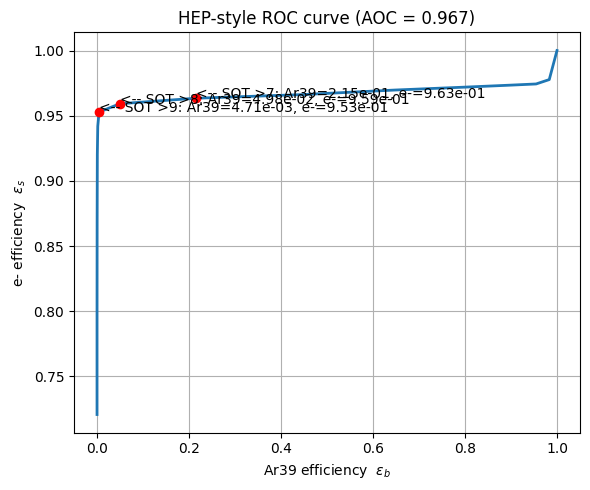

In [25]:
x=ar39_eff_adcint_df[sot_cuts].mean()
y=em_eff_adcint_df[sot_cuts].mean()
order = np.argsort(x)
x=x[order]
y=y[order]

refcut_0=7
refcut_1=8
refcut_2=9


# ------------------------------------------------------------
# Compute the AOC (area under the HEP-style curve)
# ------------------------------------------------------------
aoc = np.trapezoid(y, x)
print(f"AOC (background rejection vs signal efficiency) = {aoc:.4f}")

# ------------------------------------------------------------
# Plot the HEP-style curve
# ------------------------------------------------------------
plt.figure(figsize=(6,5))
plt.plot(x, y, lw=2)

xp, yp = ar39_eff_adcint_df[refcut_0].mean(), em_eff_adcint_df[refcut_0].mean()

plt.plot(xp, yp, 'ro')
plt.annotate(f'<-- SOT >{refcut_0}: Ar39={xp:.2e}, e-={yp:.2e}', (xp, yp))

xp, yp = ar39_eff_adcint_df[refcut_1].mean(), em_eff_adcint_df[refcut_1].mean()

plt.plot(xp, yp, 'ro')
plt.annotate(f'<-- SOT >{refcut_1}: Ar39={xp:.2e}, e-={yp:.2e}', (xp, yp))

xp, yp = ar39_eff_adcint_df[refcut_2].mean(), em_eff_adcint_df[refcut_2].mean()

plt.plot(xp, yp, 'ro')
plt.annotate(f'<-- SOT >{refcut_2}: Ar39={xp:.2e}, e-={yp:.2e}', (xp, yp))
# plt.ylim(0,1)
plt.ylabel(r"e- efficiency  $\epsilon_s$")
plt.xlabel(r"Ar39 efficiency  $\epsilon_b$")
plt.title(f"HEP-style ROC curve (AOC = {aoc:.3f})")
plt.grid(True)
plt.tight_layout()
plt.show()


# Test miniprod

In [26]:
dataset_info = {
    'readout_window' : 8500
}



from pathlib import Path
pre_prod_dir = Path('../../data/vd/mini_prod/')

with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.WARN):
    em_ws_2g = workspace.TriggerPrimitivesWorkspace(pre_prod_dir / 'vd_1x8x6_eminus_center_2333289_ana_evfix.ntuple.root', info_extra=dataset_info)


datasets_2g = {
    'e-minus': em_ws_2g
}

wirecell_ides_cut = 'sample_peak > 100 & sample_peak < 8100'

for n, df in datasets_2g.items():
    df.tps.query(wirecell_ides_cut, inplace=True)
    df.tps.extra_info['readout_window'] = 8000

None

## Trigger primitives origin

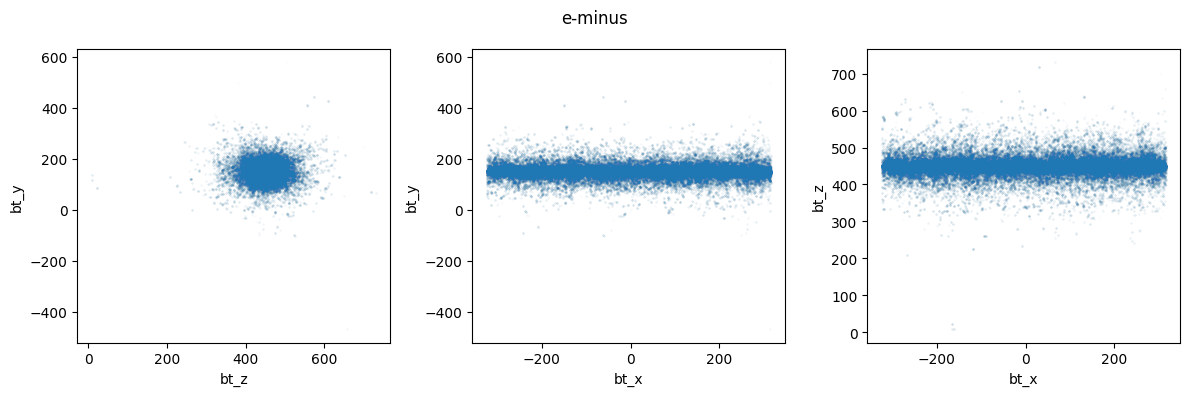

In [27]:

for n, ws in datasets_2g.items():

    fig, axes = plt.subplots(1,3, figsize=(12,4))
    ax=axes[0]
    ws.tps.query('bt_is_signal').plot.scatter(x='bt_z', y='bt_y', ax=ax, s=0.1, alpha=0.05)
    ax=axes[1]
    ws.tps.query('bt_is_signal').plot.scatter(x='bt_x', y='bt_y', ax=ax, s=0.1, alpha=0.05)
    ax=axes[2]
    ws.tps.query('bt_is_signal').plot.scatter(x='bt_x', y='bt_z', ax=ax, s=0.1, alpha=0.05)
    fig.suptitle(n)
    fig.tight_layout()

In [28]:
dataset_psel_2g = {
    n: snn.TPSignalNoiseSelector(df.tps) for n, df in datasets_2g.items()
}

,event,num_tps,0,1,2,3,4,5,6,7,8,9,10,11
0,1001,208840,208840,207965.0,207680.0,207505.0,207505.0,207168.0,205643.0,205643.0,205060.0,202692.0,202692.0,198777.0
1,1002,218588,218588,217689.0,217590.0,217270.0,217270.0,217270.0,216875.0,216875.0,216296.0,214656.0,213874.0,212721.0
2,1003,97291,97291,96821.0,96631.0,96177.0,95941.0,95941.0,95941.0,95941.0,95941.0,95173.0,93015.0,93015.0
3,1004,142520,142520,142050.0,141948.0,141799.0,141799.0,141799.0,141799.0,141275.0,140311.0,140311.0,140311.0,136846.0
4,1005,105216,105216,104701.0,104609.0,104609.0,104609.0,104609.0,104609.0,104609.0,104609.0,104609.0,104609.0,104609.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,96,196615,196615,195904.0,195810.0,195647.0,195227.0,194922.0,194570.0,194570.0,194570.0,193036.0,191788.0,189273.0
4916,97,14631,14631,13783.0,13783.0,13783.0,13589.0,13589.0,13589.0,13589.0,13589.0,13589.0,13589.0,13589.0
4917,98,208336,208336,207721.0,207336.0,207038.0,206083.0,205449.0,205076.0,202866.0,201413.0,201413.0,201413.0,192575.0
4918,99,150623,150623,149876.0,149574.0,149574.0,149574.0,149026.0,148579.0,148005.0,148005.0,148005.0,145837.0,145837.0


,event,0,1,2,3,4,5,6,7,8,9,10,11,kinetic_energy
0,1001,1.0,0.995810,0.994446,0.993608,0.993608,0.991994,0.984692,0.984692,0.981900,0.970561,0.970561,0.951815,72.100946
1,1002,1.0,0.995887,0.995434,0.993970,0.993970,0.993970,0.992163,0.992163,0.989515,0.982012,0.978434,0.973160,97.026475
2,1003,1.0,0.995169,0.993216,0.988550,0.986124,0.986124,0.986124,0.986124,0.986124,0.978230,0.956049,0.956049,42.518299
3,1004,1.0,0.996702,0.995987,0.994941,0.994941,0.994941,0.994941,0.991264,0.984500,0.984500,0.984500,0.960188,49.041896
4,1005,1.0,0.995105,0.994231,0.994231,0.994231,0.994231,0.994231,0.994231,0.994231,0.994231,0.994231,0.994231,36.048984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,96,1.0,0.996384,0.995906,0.995077,0.992941,0.991389,0.989599,0.989599,0.989599,0.981797,0.975449,0.962658,88.001455
4916,97,1.0,0.942041,0.942041,0.942041,0.928781,0.928781,0.928781,0.928781,0.928781,0.928781,0.928781,0.928781,6.397348
4917,98,1.0,0.997048,0.995200,0.993770,0.989186,0.986143,0.984352,0.973744,0.966770,0.966770,0.966770,0.924348,81.822305
4918,99,1.0,0.995041,0.993036,0.993036,0.993036,0.989397,0.986430,0.982619,0.982619,0.982619,0.968225,0.968225,80.258483


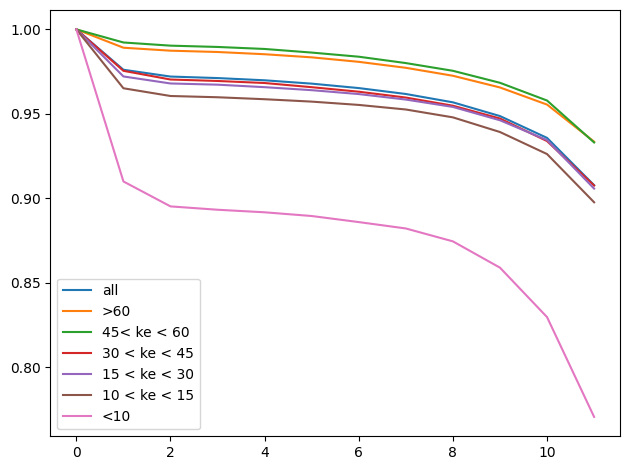

In [29]:
sot_cuts = list(range(12))


# Define main signal tp dataset
em_coll_tps = dataset_psel_2g['e-minus'].all_by_view[2]
# rad_coll_tps = dss['radiols'].all_by_view[2]
# ar39_coll_tps = dss['ar39'].all_by_view[2]


def calculate_cut_eff_by_event(tpd_df: workspace.TPDataFrame, cutvar='samples_over_threshold', metric:str='counts') -> workspace.TPDataFrame:

    match metric:
        case 'counts':
            metric = lambda x: len(x)
        case 'adc_int':
            metric = lambda x: x.adc_integral.sum()
        case _:
            return None

    ev_df = tpd_df.extra_info['event_list'][['event']].copy()

    num_tps = pd.DataFrame([(ev, metric(df)) for ev, df in tpd_df.groupby('event')], columns=['event','num_tps'], dtype=int)

    counts_df = ev_df.merge(num_tps, on="event", how="left")

    for t in sot_cuts:
        cut = f"{cutvar} > {t}"
        num_tps = pd.DataFrame([(ev, metric(df)) for ev, df in tpd_df.query(cut).groupby('event')], columns=['event',t], dtype=int)
        counts_df = counts_df.merge(num_tps, on="event", how="left")

    counts_df.fillna(0, inplace=True)

    eff_df = ev_df.copy()
    for t in sot_cuts:
        eff_df[t] = counts_df[t]/counts_df['num_tps']

    return counts_df, eff_df


c_df, em_eff_df = calculate_cut_eff_by_event(em_coll_tps, metric='adc_int')
display(c_df)
# # #------

# # # extract the event kinetic energy 
ekin = datasets_2g['e-minus'].mctruths[['event','kinetic_energy']].copy()
ekin['kinetic_energy'] = ekin['kinetic_energy']*1000

em_eff_df_ke = em_eff_df.merge(ekin, on="event", how="left")

display(em_eff_df_ke)
fig, axes = plt.subplots()
ax=axes
em_eff_df[sot_cuts].mean().plot(ax=ax, label='all')
em_eff_df_ke.query('kinetic_energy > 60')[sot_cuts].mean().plot(ax=ax, label='>60')
em_eff_df_ke.query('(kinetic_energy > 45) & (kinetic_energy <= 60)')[sot_cuts].mean().plot(ax=ax, label='45< ke < 60')
em_eff_df_ke.query('(kinetic_energy > 30) & (kinetic_energy <= 45)')[sot_cuts].mean().plot(ax=ax, label='30 < ke < 45')
em_eff_df_ke.query('(kinetic_energy > 15) & (kinetic_energy <= 30)')[sot_cuts].mean().plot(ax=ax, label='15 < ke < 30')
em_eff_df_ke.query('(kinetic_energy > 10) & (kinetic_energy <= 15)')[sot_cuts].mean().plot(ax=ax, label='10 < ke < 15')
em_eff_df_ke.query('kinetic_energy <= 10')[sot_cuts].mean().plot(ax=ax, label='<10')

plt.legend()
fig.tight_layout()


# rad_eff_df = calculate_cut_eff_by_event(rad_coll_tps, metric='adc_int')
# fig, axes = plt.subplots()
# ax=axes
# rad_eff_df[sot_cuts].mean().plot(ax=ax, label='all')
# fig.tight_layout()

# ar39_eff_df = calculate_cut_eff_by_event(ar39_coll_tps, metric='adc_int')
# display(ar39_eff_df)
# fig, axes = plt.subplots()
# ax=axes
# ar39_eff_df[sot_cuts].mean().plot(ax=ax, label='all')
# fig.tight_layout()

In [30]:
c_df.query('event==101')

,event,num_tps,0,1,2,3,4,5,6,7,8,9,10,11
100,101,85433,85433,84630.0,84153.0,83995.0,83562.0,83251.0,82792.0,82792.0,81952.0,79174.0,78224.0,75691.0


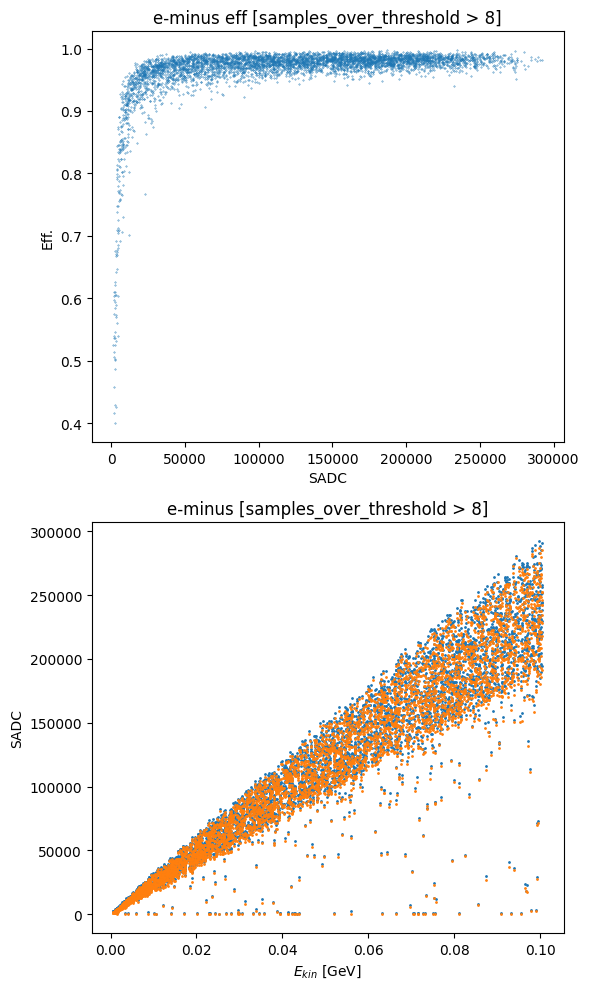

In [31]:
fig,axes = plt.subplots(2,1, figsize=(6,10))
sample='e-minus'
v=2
cut='samples_over_threshold > 8'


ds = dataset_psel_2g[sample]
tp_by_view = ds.all_by_view[v]
sum_adc_total = (tp_by_view.groupby(['event']).adc_integral.sum())
sum_adc_filtered = (tp_by_view.query(cut).groupby(['event']).adc_integral.sum())

ax=axes[0]
ax.scatter(x=sum_adc_total, y=sum_adc_filtered/sum_adc_total, s=0.1)
ax.set_title(f'e-minus eff [{cut}]')
ax.set_ylabel("Eff.")
ax.set_xlabel("SADC")

ax=axes[1]

df = datasets_2g[sample].mctruths[['event', 'kinetic_energy']]
df_nocut = df.join(sum_adc_total.to_frame(), on='event', how='outer').fillna(0)
df_cut = df.join(sum_adc_filtered.to_frame(), on='event', how='outer').fillna(0)
# print("c\n\n",c)
ax.scatter(x=df_nocut.kinetic_energy, y=df_nocut.adc_integral, s=1)
ax.scatter(x=df_cut.kinetic_energy, y=df_cut.adc_integral, s=1)
ax.set_title(sample + (f' [{cut}]' if cut else ''))
ax.set_ylabel("SADC")
ax.set_xlabel("$E_{kin}$ [GeV]")
fig.tight_layout()

slope = 2321.673976077275 +/- 9.296151027914776

intercept = 1729.4590790247573 +/- 222.28041273968194

slope = 2609.736819657782 +/- 14.024229689741759

intercept = -13232.029508450792 +/- 808.1758941802259

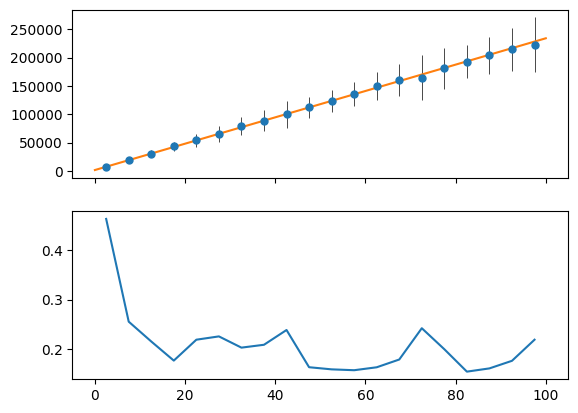

In [32]:
bins = np.linspace(0,0.1,21)
x, y, ey = [], [], []
for i, (b, df) in enumerate(df_nocut.groupby(pd.cut(df_nocut.kinetic_energy, bins), observed=False)):
    # print(i, b, len(df), df.adc_integral.mean(), df.adc_integral.std())
    x.append((b.left+(b.right-b.left)/2)*1000)
    y.append(df.adc_integral.mean())
    ey.append(df.adc_integral.std())

# print(x,y, ey)


from scipy.odr import ODR, Model, RealData

# model: y = m*x + q
def linear_model(B, x):
    m, q = B
    return m * x + q

model = Model(linear_model)
data = RealData(x, y, sy=ey)   # <-- errors in both x and y
data_all = RealData(df_nocut.kinetic_energy*1000, df_nocut.adc_integral)   # <-- errors in both x and y

odr = ODR(data, model, beta0=[1.0, 0.0])  # initial guess [m, q]
out = odr.run()

m, q = out.beta
m_err, q_err = out.sd_beta

print("slope =", m, "+/-", m_err)
print("intercept =", q, "+/-", q_err)
B1=out.beta


odr = ODR(data_all, model, beta0=[1.0, 0.0])  # initial guess [m, q]
out = odr.run()
m, q = out.beta
m_err, q_err = out.sd_beta

print("slope =", m, "+/-", m_err)
print("intercept =", q, "+/-", q_err)

fig, axes = plt.subplots(2,1, sharex=True)

ax=axes[0]
ax.errorbar(x,y, yerr=ey, ls='', ms=5, marker="o", elinewidth=0.5, ecolor='black')

lx, ly = [], []

lx.append(0)
ly.append(linear_model(B1, lx[0]))

lx.append(100)
ly.append(linear_model(B1, lx[1]))

ax.plot(lx, ly)

ax=axes[1]
ax.plot(x, np.array(ey)/np.array(y))


    

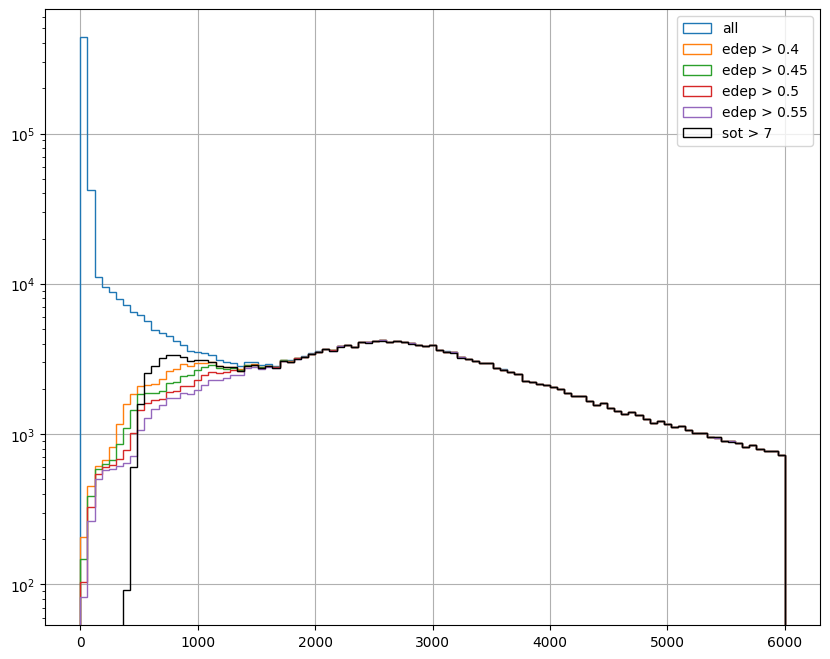

In [33]:
fig, axes = plt.subplots(figsize=(10,8)) 
ax = axes


bins=np.linspace(0,6000,100)

sot_cut = 7
# bins=np.linspace()
em_ws_2g.tps.adc_integral.hist(bins=bins, histtype='step', label='all')
# em_ws_2g.tps.query('samples_over_threshold > 8').adc_integral.hist(bins=bins, histtype='step', label='sot > 9')
for t in np.arange(0.4, 0.6, 0.05):
    em_ws_2g.tps.query(f'bt_edep > {t}').adc_integral.hist(bins=bins, histtype='step', label=f'edep > {t:.2}')
# em_ws_2g.tps.groupby('event').adc_integral.sum().hist()
em_ws_2g.tps.query(f'samples_over_threshold > {sot_cut}').adc_integral.hist(bins=bins, histtype='step', label=f'sot > {sot_cut}',color='k')

ax.legend()
ax.set_yscale('log')


# fig, axes = plt.subplots() 

# em_ws_2g.tps.bt_edep.hist(bins=100)

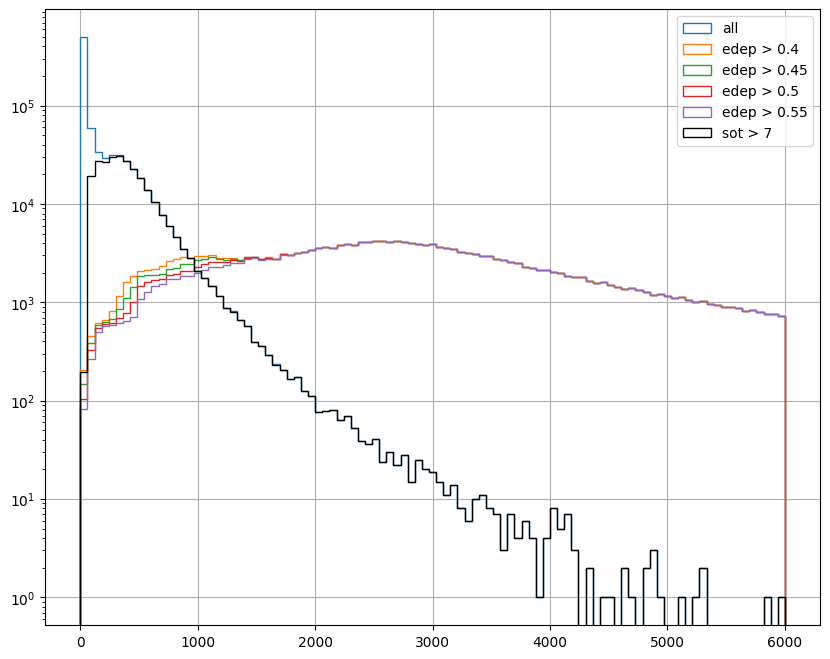

In [34]:
fig, axes = plt.subplots(figsize=(10,8)) 
ax = axes


bins=np.linspace(0,6000,100)

sot_cut = 7
# bins=np.linspace()
em_ws_2g.tps.adc_peak.hist(bins=bins, histtype='step', label='all')
# em_ws_2g.tps.query('samples_over_threshold > 8').adc_integral.hist(bins=bins, histtype='step', label='sot > 9')
for t in np.arange(0.4, 0.6, 0.05):
    em_ws_2g.tps.query(f'bt_edep > {t}').adc_integral.hist(bins=bins, histtype='step', label=f'edep > {t:.2}')
# em_ws_2g.tps.groupby('event').adc_integral.sum().hist()
em_ws_2g.tps.query(f'samples_over_threshold > {sot_cut}').adc_peak.hist(bins=bins, histtype='step', label=f'sot > {sot_cut}',color='k')

ax.legend()
ax.set_yscale('log')


# fig, axes = plt.subplots() 

# em_ws_2g.tps.bt_edep.hist(bins=100)